In [1]:
import sys
import os
import json
from collections import OrderedDict
import glob

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import scipy.stats as stats

sys.path.append("..")
import util.io as io
from util.simprop import prop
import util
from util.plot import add_panel_letters

%matplotlib inline

In [2]:
onset = 'INC'
folds = [0, 1]
PARAMS = ['q11', 'q12', 'qa21', 'qa22']
PARAM_NAMES = ['$q_{aa}$', '$q_{ab}$', '$q_{ba}^*$', '$q_{bb}^*$']

## Read hyperparameters and data

In [3]:
# Hyperparameters

def read_hyperparams(onset, fold):
    resfiles = [f"../run/learn/fold{fold}/{onset}/vep/output/chain_{ch}.csv" for ch in range(1, 5)]
    statuses = [f"../run/learn/fold{fold}/{onset}/vep/output/chain_{ch}.status" for ch in range(1, 5)]
    good_resfiles = [r for r, s in zip(resfiles, statuses) if int(open(s).read().strip()) == 1]
    res = io.parse_csv(good_resfiles)
    return np.array([res['q11'], res['q12'], res['qa21'], res['qa22']])         

qs = np.array([read_hyperparams(onset, fold) for fold in folds])

In [4]:
# Read convergence values
rhats = np.zeros((len(folds), len(PARAMS)))
neffs = np.zeros((len(folds), len(PARAMS)))

for fold in folds:
    nsamples, summary = io.parse_summary_csv(f"../run/learn/fold{fold}/{onset}/vep/output/summary.csv")
    for pid, param in enumerate(PARAMS):
        rhats[fold, pid] = summary[param]['R_hat']
        neffs[fold, pid] = summary[param]['N_Eff']

In [5]:
# Connectomes

conns = [np.genfromtxt(fn) for fn in [f"../data/conn/vep/id{i:03d}.txt" for i in range(1, 51)]]
nreg = conns[0].shape[0]

In [6]:
# Recorded data

def read_data(onsets):
    rows = []
    for onset in onsets:
        files = [fn for sid in range(1, 51) for fn in glob.glob(f"../run/solo/{onset}/vep/id{sid:03d}/input/r*_all.R")]    

        for infile in files:
            indata = io.rload(infile)
            t_sz = indata['t_sz']
            nsz = len(indata['reg_sz'])
            nns = len(indata['reg_ns'])
            nobs = nsz + nns

            rows.append(OrderedDict(
                onset=onset,
                filename=infile,
                nsz=nsz,
                nns=nns,
                nobs=nobs,
                szfrac=nsz/nobs,
                td_mean=np.mean(t_sz - np.min(t_sz)),
                td_max=np.max(t_sz - np.min(t_sz)),
                t_std=np.std(t_sz),
                td05=np.percentile(t_sz - np.min(t_sz),  5),
                td10=np.percentile(t_sz - np.min(t_sz), 10),
                td33=np.percentile(t_sz - np.min(t_sz), 33),
                td50=np.percentile(t_sz - np.min(t_sz), 50),
                td66=np.percentile(t_sz - np.min(t_sz), 66),
                td90=np.percentile(t_sz - np.min(t_sz), 90),
                td95=np.percentile(t_sz - np.min(t_sz), 95),
            ))

    dfr = pd.DataFrame(rows)
    return dfr

dfr = read_data([onset])

In [7]:
len(dfr[dfr.onset == 'INC'])

137

## Generate synthetic samples

In [14]:
NBATCHES = 100
# NBATCHES = 2

In [13]:
def generate_samples(onset, folds, qs, conns):
    NOBS_P = 0.1331
    T_FIRST = 30.0
    T_LIM = 90.0
    NSEIZURES = 137
    
    qmethod = 'sample'    
    
    rows = []
    
    for fold in folds:
        for batch in range(NBATCHES):
            print(batch, end=' ')
            for seizure in range(NSEIZURES):
                reg_sz = []

                while len(reg_sz) < 1:
                    q = qs[fold]

                    if qmethod == 'sample':            
                        qgen = q[:, np.random.choice(q.shape[1])]
                    else:
                        qgen = np.mean(q, axis=1)

                    conn = conns[np.random.choice(len(conns))]
                    c = np.random.normal(0, 1, size=nreg)
                    nobs = np.maximum(np.random.binomial(nreg, NOBS_P), 5)
                    reg_obs = np.sort(np.random.choice(np.r_[:nreg], size=nobs, replace=False))

                    t = prop(c, conn, qgen)

                    t_obs = np.array([t[reg] for reg in reg_obs])
                    t_shift = -np.min(t_obs) + T_FIRST
                    reg_ns, reg_sz, t_sz = util.prepdata.move_late_seizing_regs(np.array([], dtype=int),
                                                                                reg_obs, t_obs + t_shift, T_LIM)

                rows.append(OrderedDict(
                    qmethod=qmethod,
                    onset=onset,
                    fold=fold,
                    batch=batch,
                    seizure=seizure,
                    nsz=len(reg_sz),
                    nns=len(reg_ns),
                    nobs=nobs,
                    szfrac=len(reg_sz)/nobs,
                    td_mean=np.mean(t_sz - np.min(t_sz)),
                    td_max=np.max(t_sz - np.min(t_sz)),
                    t_std=np.std(t_sz),
                    t_shift=t_shift,
                    tfirst=np.min(t),
                    td05=np.percentile(t_sz - np.min(t_sz),  5),
                    td10=np.percentile(t_sz - np.min(t_sz), 10),
                    td33=np.percentile(t_sz - np.min(t_sz), 33),
                    td50=np.percentile(t_sz - np.min(t_sz), 50),
                    td66=np.percentile(t_sz - np.min(t_sz), 66),
                    td90=np.percentile(t_sz - np.min(t_sz), 90),
                    td95=np.percentile(t_sz - np.min(t_sz), 95),
                ))
        print('')
    df = pd.DataFrame(rows)
    return df

np.random.seed(43)
dfs = generate_samples(onset, folds, qs, conns)

0 1 
0 1 


In [ ]:
dfs.to_pickle("data/postpredcheck.pkl")

In [15]:
dfs = pd.read_pickle("data/postpredcheck.pkl")

## Figures

In [16]:
def plot_predpostcheck(dfr, dfs, onset, var, bins, xlabel, percent=False, fmt='.0f',
                       legendloc=None, ax=None, ylabel=False):
    nbins = len(bins) - 1
    mids = (bins[1:] + bins[:-1])/2.

    # Real data
    dffr = dfr[dfr.onset == onset]
    histr, _ = np.histogram(dffr[var], bins=bins)

    # Simulated data
    hists = np.zeros((len(folds), NBATCHES, nbins))
    for fold in folds:
        for batch in range(NBATCHES):
            dffs = dfs[(dfs.onset == onset) & (dfs.fold == fold) & (dfs.batch == batch)]
            hists[fold, batch, :], _ = np.histogram(dffs[var], bins=bins)

    if ax is None:
        plt.figure(figsize=(5,4))
    else:
        plt.sca(ax)    
    
    # plt.scatter(mids, histr, color='tab:red', s=100, label='Data')
    plt.bar(bins[:-1], histr, width=(bins[1]-bins[0]), align='edge', color='tab:red',
            ec='k', alpha=0.6, label='Data')

    for fold, color in zip([0, 1], ['b', 'g']):
        plt.plot(mids, np.mean(hists[fold], axis=0), color=color, label=f"Sim. (fold {fold+1})")
        plt.fill_between(mids,
                         np.percentile(hists[fold], 5, axis=0),
                         np.percentile(hists[fold], 95, axis=0),
                         alpha=0.3, color=color, zorder=5)

    if percent:
        xticks = [f"[{100*bins[i]:{fmt}}; {100*bins[i+1]:{fmt}}{']' if i == nbins-1 else ')'}%"
                  for i in range(nbins)]
    else:
        xticks = [f"[{bins[i]:{fmt}}; {bins[i+1]:{fmt}}{']' if i == nbins-1 else ')'}" for i in range(nbins)]

    plt.xticks(mids, xticks, rotation='vertical')
    plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel("Number of seizures")
                  
    if legendloc is not None:
        plt.legend(loc=legendloc)

In [17]:


def plot_hyperparam(ax, values, lims, rhats, neffs, pid, legend=False, ylabel=False):
    nfolds, nsamples = values.shape
    colors = ['b', 'g']
    
    plt.sca(ax)
        
    x = np.linspace(lims[0], lims[1], 500)
    lines = []
    for i in range(nfolds):
        kernel = stats.gaussian_kde(values[i])
        line = plt.plot(x, kernel(x), color=colors[i], ls='-', lw=2, label=f"Fold {i+1}")
        lines.append(line[0])
    plt.ylim(bottom=0.)
        
    # Prior
    if pid in [0, 1]:
        prior = stats.norm(0, 30)
    else:
        prior = stats.halfnorm(0, 30)
    
    # ax2 = ax.twinx()
    line = plt.plot(x, prior.pdf(x), color='k', ls='--', lw=2, zorder=-1, label='prior')
    # lines.append(line[0])
    # plt.ylim(bottom=0., top=3*np.max(prior.pdf(x)))        
    # plt.legend(lines, [l.get_label() for l in lines], loc='best')
    plt.xlabel("Parameter value")
    if ylabel:
        plt.ylabel("Density")
    plt.title(PARAM_NAMES[pid])
    # plt.ylim(-0.03, 1.03)
    # plt.xlim(-20, 120)
    # plt.yscale('log')
    
    if legend:
        plt.legend(loc='upper right')
    
    for i in range(nfolds):
        plt.text(0.02, 0.94 - 0.3*i, "$\hat{R}$ = %.2f\n$N_{eff}$ = %.2f" % (rhats[i], neffs[i]),
                 color=colors[i], ha='left', va='top', fontsize=10, transform=ax.transAxes)
        # plt.text(0.05, 0.87, "$\hat{R}$ = %.2f\n $N_{eff}$ = %.2f" % (rhats[1], neffs[1]), color=colors[1], **targs)
    
    
    

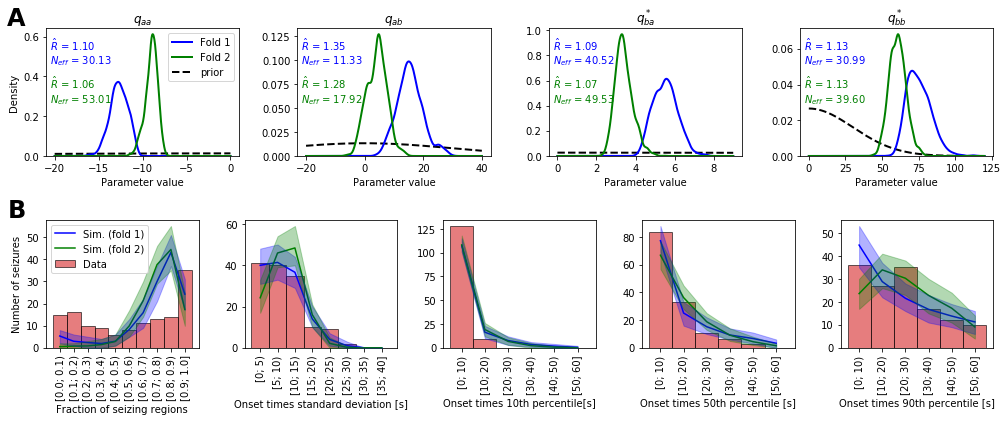

In [18]:
fig = plt.figure(figsize=(14, 6))
# plt.suptitle("Posterior predictive checks", fontsize=14)

# gs = gridspec.GridSpec(1, 5, wspace=0.3, left=0.04, right=0.99, bottom=0.3, top=0.90)
gs = gridspec.GridSpec(2, 1, hspace=0.5, left=0.04, right=0.98, bottom=0.2, top=0.94)


# Parameter values
gs1 = gs[0].subgridspec(1, 4, wspace=0.3)
axa1 = plt.subplot(gs1[0])
plot_hyperparam(axa1,                qs[:, 0], (-20,   0), rhats[:, 0], neffs[:, 0], 0, legend=True, ylabel=True)
plot_hyperparam(plt.subplot(gs1[1]), qs[:, 1], (-20,  40), rhats[:, 1], neffs[:, 1], 1)
plot_hyperparam(plt.subplot(gs1[2]), qs[:, 2], (  0,   9), rhats[:, 2], neffs[:, 2], 2)
plot_hyperparam(plt.subplot(gs1[3]), qs[:, 3], (  0, 120), rhats[:, 3], neffs[:, 3], 3)


# Posterior predictive checks
gs2 = gs[1].subgridspec(1, 5, wspace=0.3)

axb1 = plt.subplot(gs2[0])
plot_predpostcheck(dfr, dfs, 'INC', 'szfrac', np.linspace(0, 1, 11), "Fraction of seizing regions",
                   percent=False, fmt='.1f', legendloc='upper left', ylabel=True, ax=axb1)

axb2 = plt.subplot(gs2[1])
plot_predpostcheck(dfr, dfs, 'INC', 't_std', np.linspace(0, 40, 9), "Onset times standard deviation [s]", ax=axb2)

axb3 = plt.subplot(gs2[2])
plot_predpostcheck(dfr, dfs, 'INC', 'td10',  np.linspace(0, 60, 7), "Onset times 10th percentile[s]", ax=axb3)

axb4 = plt.subplot(gs2[3])
plot_predpostcheck(dfr, dfs, 'INC', 'td50',  np.linspace(0, 60, 7), "Onset times 50th percentile [s]", ax=axb4)

axb5 = plt.subplot(gs2[4])
plot_predpostcheck(dfr, dfs, 'INC', 'td90',  np.linspace(0, 60, 7), "Onset times 90th percentile [s]", ax=axb5)


add_panel_letters(fig, [axa1, axb1], fontsize=24, xpos=[-0.2, -0.25], ypos=1.02)

plt.savefig("img/postpredcheck.pdf")

## Pair plots

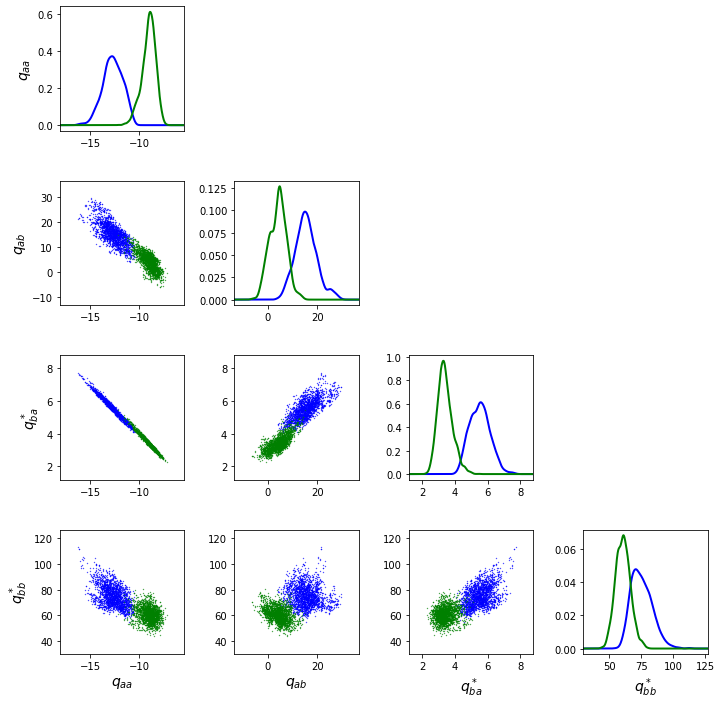

In [19]:
def limits(values, pad=0.2):
    mn = np.min(values)
    mx = np.max(values)    
    return mn - pad*(mx - mn), mx + pad*(mx - mn)    


def pairplots(qs):
    nfolds, nparams, nsamples = qs.shape
    colors = ['b', 'g']    
    
    fig = plt.figure(figsize=(10, 10))

    gs = gridspec.GridSpec(4, 4, hspace=0.4, wspace=0.4, left=0.08, right=0.98, bottom=0.08, top=0.98)

    for i in range(4):
        for j in range(4):
            xlim = limits(qs[:, j])
            ylim = limits(qs[:, i])
            
            if i > j:
                ax = plt.subplot(gs[i, j])
                for k in range(nfolds):
                    plt.scatter(qs[k, j], qs[k, i], color=colors[k], s=0.1, alpha=1)
                plt.xlim(xlim); plt.ylim(ylim)
            if i == j:
                ax = plt.subplot(gs[i, j])
                x = np.linspace(xlim[0], xlim[1], 500)
                for k in range(nfolds):
                    kernel = stats.gaussian_kde(qs[k, i])
                    plt.plot(x, kernel(x), color=colors[k], ls='-', lw=2, label=f"Fold {k+1}")
                plt.xlim(xlim)
                
            if j == 0:
                plt.ylabel(PARAM_NAMES[i], fontsize=14)
            if i == nparams-1:
                plt.xlabel(PARAM_NAMES[j], fontsize=14)
                
    plt.savefig("img/hyperparams-pairplots.pdf")

pairplots(qs) 